# IE0005 Group 1
## Cuisine Prediction from Ingredients

Problem statement: How can we classify the category of cuisine given a list of ingredients from a recipe?

Objective: Implement a prediction system that uses recipe-ingredient data from Kaggle challenge (https://www.kaggle.com/competitions/whats-cooking/data) to classify the category of cuisine of a given recipe




In [122]:
# Import the libraries

import nltk

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split


## Extract the data from the train.json file

Create a DataFrame to store the file data

In [131]:
# Read data from train.json file
recipe_data = pd.read_json('data/train.json')
recipe_data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


## Inspect the attributes of the DataFrames

Print out the sizes and data types of the DataFrames, checking for null values as well

In [132]:
# Check data type
print("Data type:", type(recipe_data))

# Check size of dataset
print('Data dim:', recipe_data.shape) 
print('Columns:', recipe_data.columns)

# Check variable types in dataset
print('\n', recipe_data.dtypes)

# Checking for null values in the data
print('\nWhether Null exists:\n', recipe_data.isnull().sum())

Data type: <class 'pandas.core.frame.DataFrame'>
Data dim: (39774, 3)
Columns: Index(['id', 'cuisine', 'ingredients'], dtype='object')

 id              int64
cuisine        object
ingredients    object
dtype: object

Whether Null exists:
 id             0
cuisine        0
ingredients    0
dtype: int64


## Lemmatization

Reduce words to their basic form to reduce variations in what would essentially be the same ingredient (i.e., tomatoes and tomato, baked and bake).

The ingredients are further reduced by removing duplicates, only leaving unique ingredients

In [133]:
# Lemmatization to reduce words to base form i.e. tomatoes to tomato
lemmatizer = WordNetLemmatizer()

# Convert lowercase for all recipe ingredients
recipe_data['ingredients_lower'] = recipe_data['ingredients'].apply(
    lambda ingredients: [item.lower() for item in ingredients]
)
recipe_data['ingredients_lem'] = recipe_data['ingredients_lower'].apply(
    lambda ingredients: [lemmatizer.lemmatize(item) for item in ingredients]
)

# Convert list of ingredients to string, separated by comma
recipe_data['ingredients_str'] = recipe_data['ingredients_lem'].apply(lambda x: ', '.join(x))

# Check for duplicates based on the 'id' column
duplicate_ids = recipe_data.duplicated(subset=['id']).sum()
print("No. of Duplicate IDs:\n", duplicate_ids)

# Check for duplicates based on 'cuisine' and 'ingredients_str' column
duplicate_rows = recipe_data.duplicated(subset=['cuisine', 'ingredients_str']).sum()
print("No. of duplicate rows:\n", duplicate_rows)

# Drop duplicate rows based on 'cuisine' and 'ingredients_str' columns, keeping the first occurrence
recipe_data = recipe_data.drop_duplicates(subset=['cuisine', 'ingredients_str'], keep='first')
# Reset index after dropping duplicates
recipe_data = recipe_data.reset_index(drop=True)
# Verify duplicate rows have been dropped
duplicate_rows = recipe_data.duplicated(subset=['cuisine', 'ingredients_str']).sum()
print("Remaining no. of duplicate rows:\n", duplicate_rows)

print('New data dim:', recipe_data.shape) 
recipe_data.head(n = 10)

No. of Duplicate IDs:
 0
No. of duplicate rows:
 97
Remaining no. of duplicate rows:
 0
New data dim: (39677, 6)


,id,cuisine,ingredients,ingredients_lower,ingredients_lem,ingredients_str
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, black olives, grape tomatoes...","romaine lettuce, black olives, grape tomatoes,..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[plain flour, ground pepper, salt, tomatoes, g...","[plain flour, ground pepper, salt, tomato, gro...","plain flour, ground pepper, salt, tomato, grou..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, pepper, salt, mayonaise, cooking oil, g...","[egg, pepper, salt, mayonaise, cooking oil, gr...","egg, pepper, salt, mayonaise, cooking oil, gre..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat, salt]","water, vegetable oil, wheat, salt"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[black pepper, shallots, cornflour, cayenne pe...","[black pepper, shallot, cornflour, cayenne pep...","black pepper, shallot, cornflour, cayenne pepp..."
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...","[plain flour, sugar, butter, eggs, fresh ginge...","[plain flour, sugar, butter, egg, fresh ginger...","plain flour, sugar, butter, egg, fresh ginger ..."
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli...","[olive oil, salt, medium shrimp, pepper, garli...","[olive oil, salt, medium shrimp, pepper, garli...","olive oil, salt, medium shrimp, pepper, garlic..."
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo...","[sugar, pistachio nuts, white almond bark, flo...","[sugar, pistachio nuts, white almond bark, flo...","sugar, pistachio nuts, white almond bark, flou..."
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por...","[olive oil, purple onion, fresh pineapple, por...","[olive oil, purple onion, fresh pineapple, por...","olive oil, purple onion, fresh pineapple, pork..."
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-...","[chopped tomatoes, fresh basil, garlic, extra-...","[chopped tomatoes, fresh basil, garlic, extra-...","chopped tomatoes, fresh basil, garlic, extra-v..."


## View the attributes of this cleaned DataFrame

Methods used include .nunique(), .unique() and .value_counts() 

In [134]:
# Find how many unique cuisines are there
print(recipe_data['cuisine'].nunique())

# What are the unique cuisines?
print(recipe_data['cuisine'].unique())

20
['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']


In [135]:
# Find how many recipes are there
recipe_data['ingredients_lem']

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomato, gro...
2        [egg, pepper, salt, mayonaise, cooking oil, gr...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallot, cornflour, cayenne pep...
                               ...                        
39672    [light brown sugar, granulated sugar, butter, ...
39673    [kraft zesty italian dressing, purple onion, b...
39674    [egg, citrus fruit, raisin, sourdough starter,...
39675    [boneless chicken skinless thigh, minced garli...
39676    [green chile, jalapeno chilies, onion, ground ...
Name: ingredients_lem, Length: 39677, dtype: object

In [136]:
# Example of a single recipe column
recipe_data['ingredients_lem'][4]

['black pepper',
 'shallot',
 'cornflour',
 'cayenne pepper',
 'onion',
 'garlic paste',
 'milk',
 'butter',
 'salt',
 'lemon juice',
 'water',
 'chili powder',
 'passata',
 'oil',
 'ground cumin',
 'boneless chicken skinless thigh',
 'garam masala',
 'double cream',
 'natural yogurt',
 'bay leaf']

In [137]:
# Count recipes for each cuisine
recipe_data['cuisine'].value_counts()

cuisine
italian         7831
mexican         6429
southern_us     4299
indian          2997
chinese         2666
french          2637
cajun_creole    1541
thai            1536
japanese        1417
greek           1172
spanish          987
korean           827
vietnamese       821
moroccan         818
british          803
filipino         755
irish            667
jamaican         522
russian          489
brazilian        463
Name: count, dtype: int64

## Data Visualisation

Visualise the number of recipes each cuisine has with each other using statistical plots like countplot, histograms, pie charts and WordCloud Generator

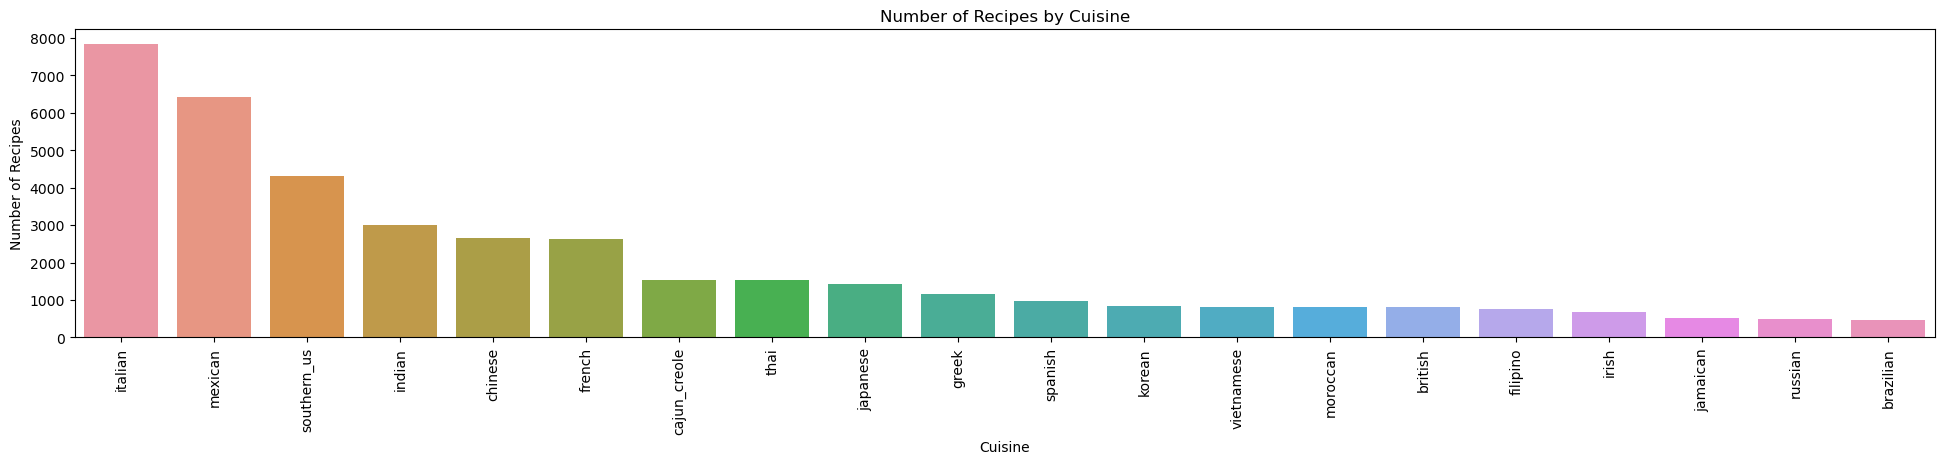

In [148]:
# Visualise on count plot

plt.figure(figsize=(24, 4))  # Adjust figure size as needed
sb.countplot(data=recipe_data, x='cuisine', order=recipe_data['cuisine'].value_counts().index)
plt.xticks(rotation=90)  # Rotate x-axis labels if needed for readability
plt.title('Number of Recipes by Cuisine')
plt.xlabel('Cuisine')
plt.ylabel('Number of Recipes')
plt.show()

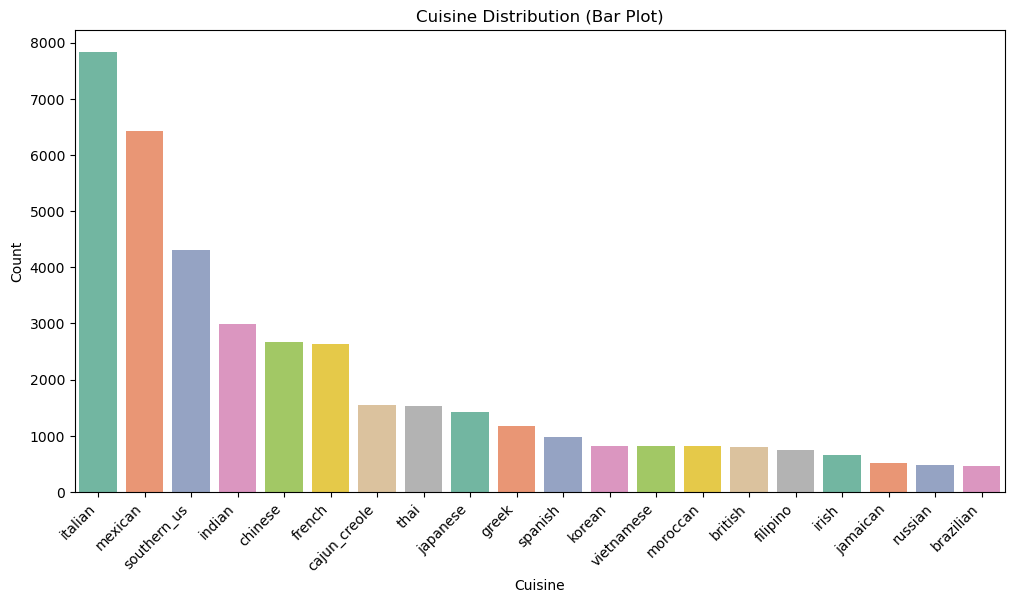

In [139]:
# Visualise cuisine distribution on a bar graph
def plot_cuisine_distribution_bar():
    plt.figure(figsize=(12, 6))
    sb.countplot(data=recipe_data, x='cuisine', order=recipe_data['cuisine'].value_counts().index, palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.title('Cuisine Distribution (Bar Plot)')
    plt.xlabel('Cuisine')
    plt.ylabel('Count')
    plt.show()

plot_cuisine_distribution_bar()

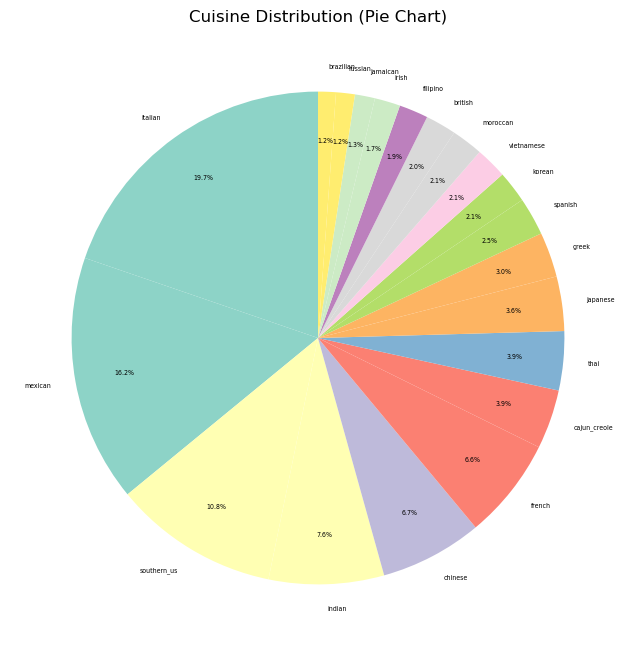

In [140]:
# Visualise cuisine distribution of dataset on a pie chart
def plot_cuisine_distribution_pie():
    plt.figure(figsize=(8, 8))
    fig = recipe_data['cuisine'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3', pctdistance = 0.8)
    plt.setp(fig.texts, size = 4.5)
    plt.title('Cuisine Distribution (Pie Chart)')
    plt.ylabel('')
    plt.show()

plot_cuisine_distribution_pie()

## WordCloud Generator

Generate a graphic with words of cuisines varying sizes that correspond with the number of recipes. The bigger the cuisine word, the more recipes it has

Note: you may need to restart the kernel to use updated packages.


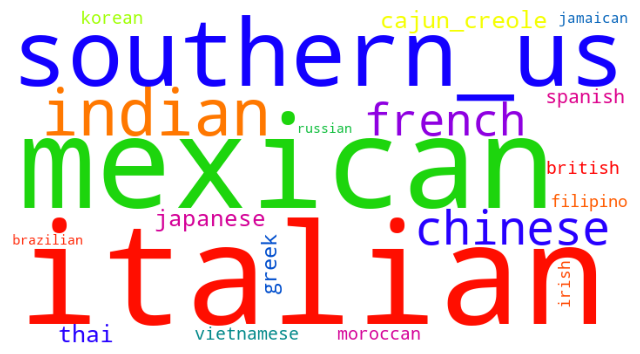

In [141]:
# Install wordcloud library
%pip install wordcloud

# Generate wordcloud, largest size -> most number of recipes
from wordcloud import WordCloud

x = recipe_data['cuisine'].values

plt.subplots(figsize = (8,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 712,
                    height = 384,
                    colormap = 'prism').generate(' '.join(x))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.savefig('cuisines.png')
plt.show()

## Ingredient Sorting

Visualise number of each ingredient with plottings

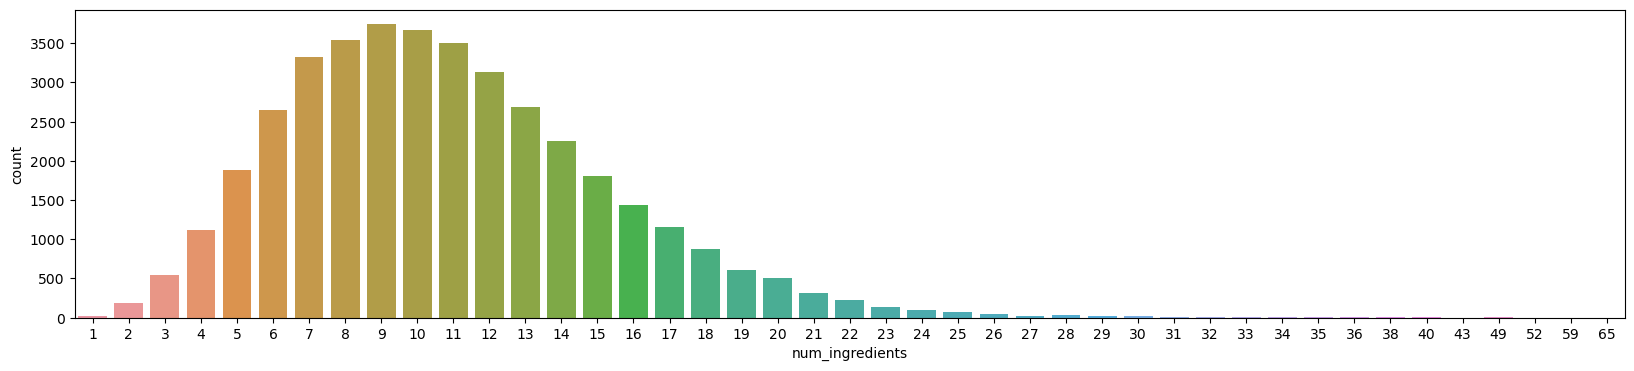

In [142]:
# Visualise number of ingredients for each recipe
recipe_data['num_ingredients'] = recipe_data['ingredients_lem'].apply(lambda x: len(x))

plt.figure(figsize=(20,4))
sb.countplot(x='num_ingredients', data=recipe_data)
plt.show()

In [143]:
recipe_data_exploded = recipe_data.explode('ingredients_lem')

# How many unique ingredients are there?
print("Total no. of unique ingredients:", recipe_data_exploded['ingredients_lem'].nunique())
recipe_data_exploded_sorted = recipe_data_exploded.sort_values(by='ingredients_lem').reset_index(drop=True)
print("Unique ingredients:", recipe_data_exploded_sorted['ingredients_lem'].unique()[:200])

Total no. of unique ingredients: 6703
Unique ingredients: ['(    oz.) tomato sauce' '(   oz.) tomato paste'
 '(10 oz.) frozen chopped spinach'
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry'
 '(14 oz.) sweetened condensed milk' '(14.5 oz.) diced tomatoes'
 '(15 oz.) refried beans' '1% low-fat buttermilk'
 '1% low-fat chocolate milk' '1% low-fat cottage cheese' '1% low-fat milk'
 '2 1/2 to 3 lb. chicken, cut into serving pieces'
 '2% low fat cheddar chees' '2% low-fat cottage cheese'
 '2% lowfat greek yogurt' '2% milk shredded mozzarella cheese'
 '2% reduced-fat milk' '25% less sodium chicken broth'
 '33% less sodium cooked deli ham' '33% less sodium cooked ham'
 '33% less sodium ham' '33% less sodium smoked fully cooked ham'
 '40% less sodium taco seasoning' '40% less sodium taco seasoning mix'
 '7 up' '8 ounc ziti pasta, cook and drain' '95% lean ground beef'
 'a taste of thai rice noodles' 'abalone' 'abbamele' 'absinthe'
 'abura age' 'acai juice' 'accent' 'accent seasonin

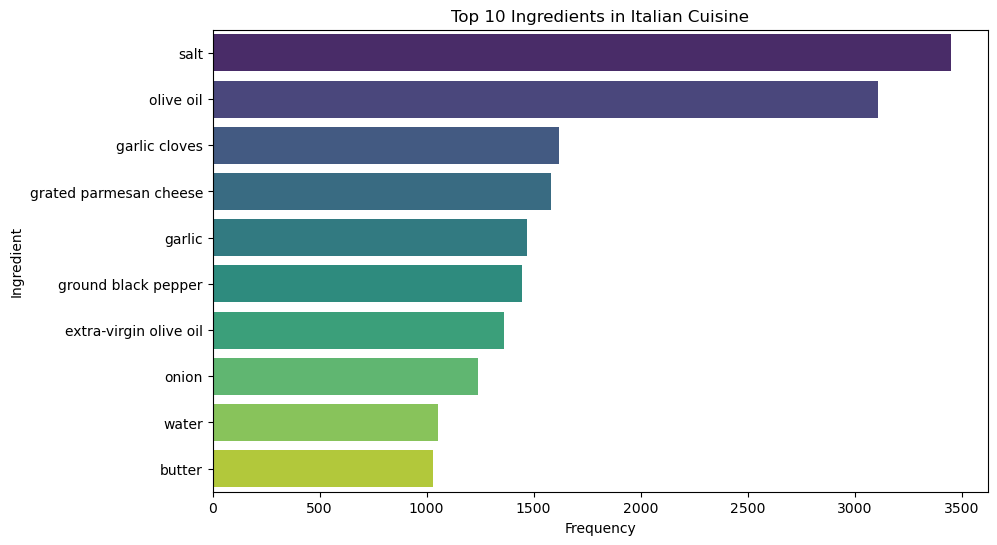

In [144]:
# Get top 10 ingredients of cuisine
def plot_top_ingredients(cuisine, top_n=10):
    top_ingredients = (recipe_data_exploded[recipe_data_exploded['cuisine'] == cuisine].value_counts('ingredients_lem').head(top_n))

    plt.figure(figsize=(10, 6))
    sb.barplot(x=top_ingredients.values, y=top_ingredients.index, palette='viridis')
    plt.title(f"Top {top_n} Ingredients in {cuisine.capitalize()} Cuisine")
    plt.xlabel("Frequency")
    plt.ylabel("Ingredient")
    plt.show()

# Visualise top 10 ingredients for italian cuisine
plot_top_ingredients('italian')

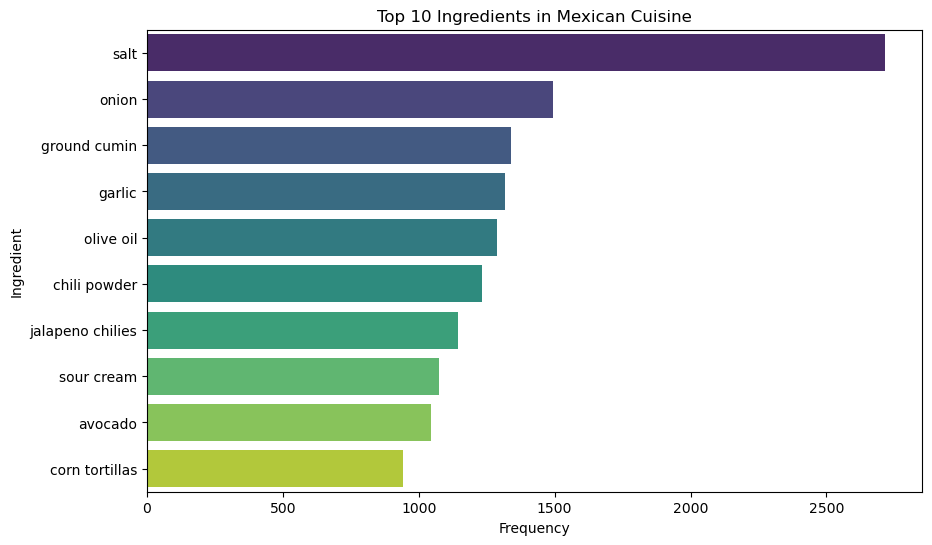

In [145]:
# Visualise top 10 ingredients for mexican cuisine
plot_top_ingredients('mexican')

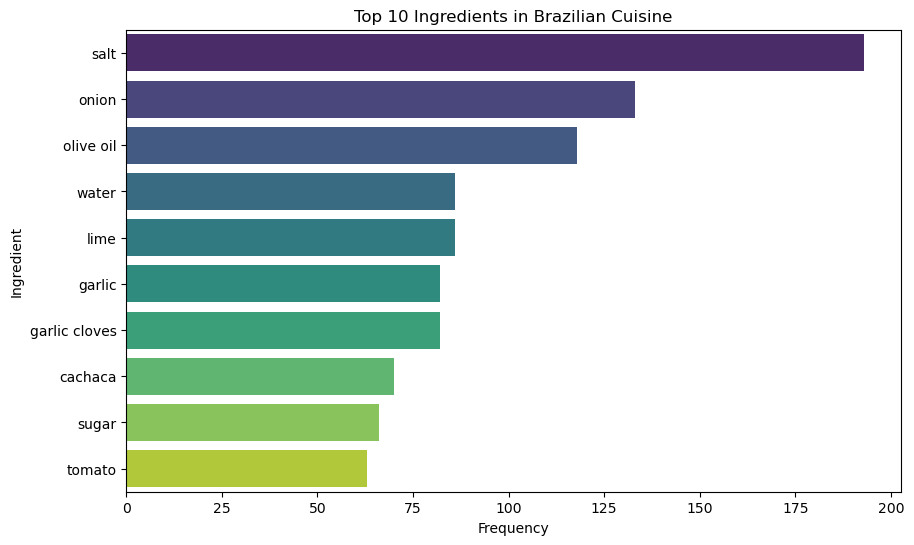

In [147]:
# Visualise top 10 ingredients for brazil cuisine
plot_top_ingredients('brazilian')

## Remove ingredients that are common across many cuisines



From the bar graphs of the top 10 ingredients in various cuisines, we found out that there were common ingredients e.g. water, salt, sugar, oil across the cuisine types. As these could introduce noise when applying machine learning tools, we decided to remove them

In [44]:
# List of common ingredients to remove
common_ingredients = ["water", "sugar", "salt", "pepper", "black pepper", "ground pepper", "ground black pepper",
                         "shallot", "vegetable oil", "cooking oil", "olive oil", "extra-virgin olive oil",
                         "condiment", "seasoning", "onion", "purple onion", "yellow onion", "garlic", "garlic cloves", "butter"]

# Apply the function to clean the 'ingredients_lem' column
recipe_data['ingredients_lem'] = recipe_data['ingredients_lem'].apply(
     lambda ingredients: [item for item in ingredients if item not in common_ingredients]
)

# Update the 'ingredients_str' column based on the 'ingredients_lem' list
recipe_data['ingredients_str'] = recipe_data['ingredients_lem'].apply(lambda x: ', '.join(x))

# Recalculate num_ingredients after cleaning
recipe_data['num_ingredients'] = recipe_data['ingredients_lem'].apply(len)

# Display the updated DataFrame to confirm cleaning
recipe_data.head(10)

,id,cuisine,ingredients,ingredients_lower,ingredients_lem,ingredients_str,num_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, black olives, grape tomatoes...","romaine lettuce, black olives, grape tomatoes,...",5
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[plain flour, ground pepper, salt, tomatoes, g...","[plain flour, tomato, thyme, egg, green tomato...","plain flour, tomato, thyme, egg, green tomatoe...",7
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, pepper, salt, mayonaise, cooking oil, g...","[egg, mayonaise, green chilies, grilled chicke...","egg, mayonaise, green chilies, grilled chicken...",7
3,22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat, salt]",[wheat],wheat,1
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[black pepper, shallots, cornflour, cayenne pe...","[cornflour, cayenne pepper, garlic paste, milk...","cornflour, cayenne pepper, garlic paste, milk,...",14
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...","[plain flour, sugar, butter, eggs, fresh ginge...","[plain flour, egg, fresh ginger root, ground c...","plain flour, egg, fresh ginger root, ground ci...",9
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli...","[olive oil, salt, medium shrimp, pepper, garli...","[medium shrimp, chopped cilantro, jalapeno chi...","medium shrimp, chopped cilantro, jalapeno chil...",9
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo...","[sugar, pistachio nuts, white almond bark, flo...","[pistachio nuts, white almond bark, flour, van...","pistachio nuts, white almond bark, flour, vani...",8
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por...","[olive oil, purple onion, fresh pineapple, por...","[fresh pineapple, pork, poblano peppers, corn ...","fresh pineapple, pork, poblano peppers, corn t...",9
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-...","[chopped tomatoes, fresh basil, garlic, extra-...","[chopped tomatoes, fresh basil, kosher salt, f...","chopped tomatoes, fresh basil, kosher salt, fl...",4


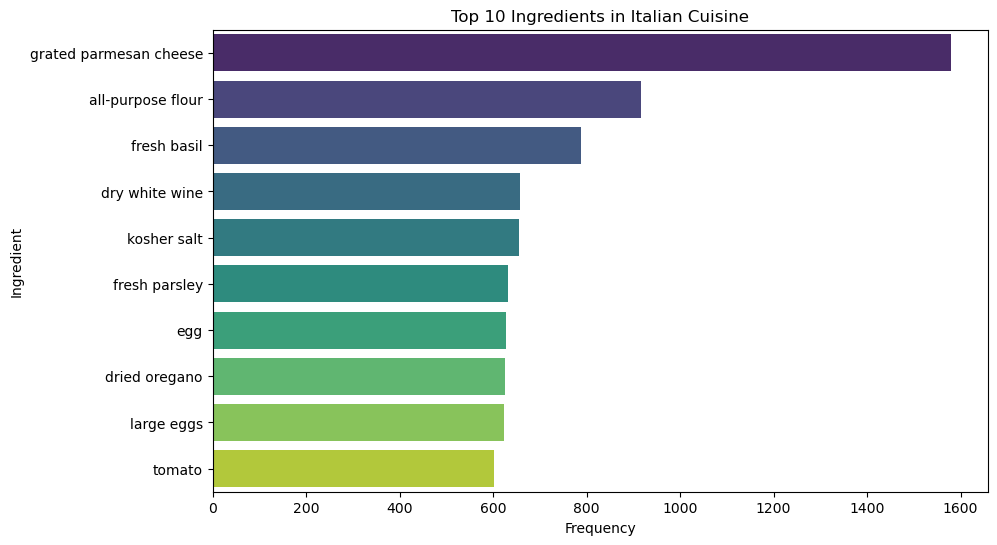

In [25]:
recipe_data_exploded = recipe_data.explode('ingredients_lem')

# Visualise top 10 ingredients for italian cuisine
plot_top_ingredients('italian')

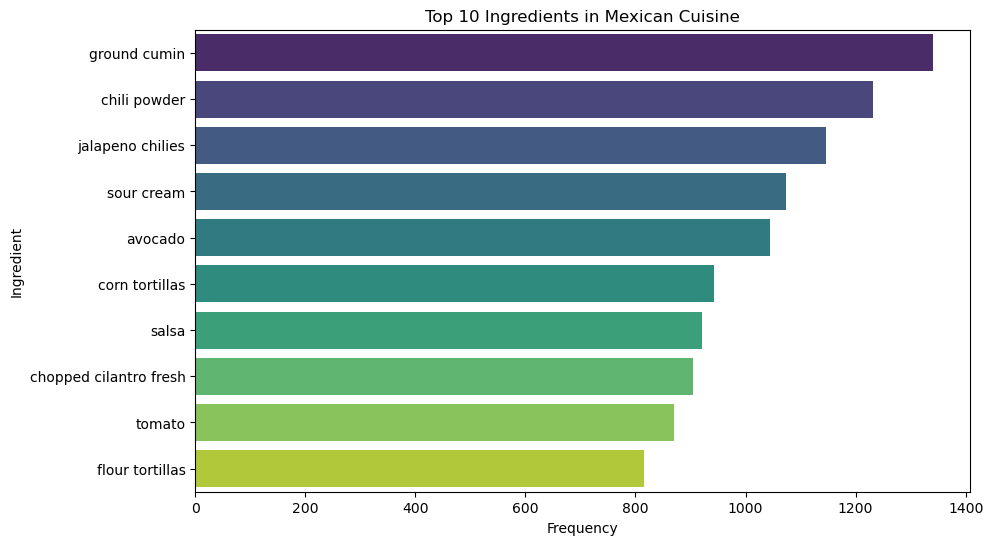

In [126]:
# Visualise top 10 ingredients for mexican cuisine
plot_top_ingredients('mexican')

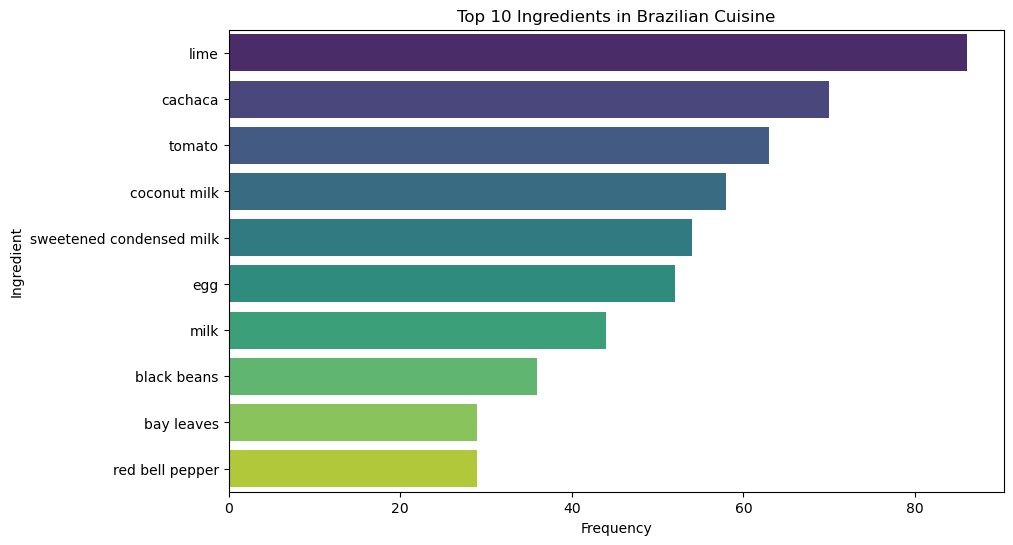

In [128]:
# Visualise top 10 ingredients for Southern US cuisine
plot_top_ingredients('brazilian')

## Group the data

Transform the dataset to be an array with all the neccessary ingredients. Utilise a CountVectoriser() object to count the ingredient strings using a Bag-Of-Words (BoW) model

In [50]:
# Transform the dataset so that each row represents a cuisine and contains a single string with all the ingredients used across recipes of that cuisine
cuisine_ingredients = recipe_data.groupby('cuisine')['ingredients_str'].apply(lambda x: ' '.join(x)).reset_index()



# To convert the textual data of ingredients into a numerical format using a bag-of-words model
vectorizer = CountVectorizer()
ingredient_matrix = vectorizer.fit_transform(cuisine_ingredients['ingredients_str']).toarray()

# Show the vector size
number_of_cuisines, vector_size = ingredient_matrix.shape

print("Number of cuisines:",number_of_cuisines)
print("Vector size:",vector_size)
print(vectorizer.get_feature_names_out())

Number of cuisines: 20
Vector size: 3002
['00' '10' '100' ... 'ziti' 'zucchini' 'épices']


## Create a DataFrame from the matrix  

Each row represents a cuisine, and each row a unique ingredient. Each cell corresponds to a count of that ingredient for said cuisine.

This format makes it easier to visualise and compute relationships between cuisines and their shared ingredients.

Thus, we calculate the correlation between them. The correlation values range from -1 to 1

In [ ]:
# Create a DataFrame for ingredient matrix with cuisines as index
ingredient_df = pd.DataFrame(ingredient_matrix, index=cuisine_ingredients['cuisine'], columns=vectorizer.get_feature_names_out())



# Calculate correlation matrix between cuisines
cuisine_correlation = ingredient_df.T.corr()  # Transpose to get correlation across cuisines
cuisine_correlation

cuisine,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
cuisine,,,,,,,,,,,,,,,,,,,,
brazilian,1.000000,0.580831,0.658474,0.439457,0.625740,0.650146,0.552962,0.593421,0.562573,0.594306,0.695495,0.460317,0.363876,0.676835,0.509188,0.586674,0.676681,0.727687,0.686447,0.557734
british,0.580831,1.000000,0.461292,0.330571,0.495386,0.817104,0.470475,0.427725,0.905310,0.536510,0.558891,0.395659,0.276495,0.451349,0.410732,0.883071,0.875686,0.503061,0.338618,0.321151
cajun_creole,0.658474,0.461292,1.000000,0.519573,0.579078,0.584640,0.560105,0.486997,0.499915,0.620576,0.664057,0.473538,0.419077,0.630519,0.493638,0.516681,0.675126,0.774291,0.543496,0.501517
chinese,0.439457,0.330571,0.519573,1.000000,0.836513,0.371484,0.321137,0.427245,0.317347,0.379484,0.545463,0.891298,0.861580,0.450431,0.335313,0.352506,0.453500,0.461079,0.718632,0.783786
filipino,0.625740,0.495386,0.579078,0.836513,1.000000,0.474612,0.361439,0.458049,0.472240,0.431508,0.622334,0.790714,0.691773,0.504062,0.359234,0.504358,0.581332,0.512150,0.736732,0.771097
french,0.650146,0.817104,0.584640,0.371484,0.474612,1.000000,0.685636,0.460841,0.781788,0.767632,0.577509,0.408776,0.281242,0.541181,0.522960,0.847700,0.802111,0.754748,0.443445,0.404030
greek,0.552962,0.470475,0.560105,0.321137,0.361439,0.685636,1.000000,0.517263,0.488824,0.784062,0.541020,0.354222,0.255248,0.580871,0.642514,0.568039,0.547778,0.726851,0.438834,0.412951
indian,0.593421,0.427725,0.486997,0.427245,0.458049,0.460841,0.517263,1.000000,0.434393,0.436468,0.672816,0.485259,0.372151,0.636666,0.769526,0.444131,0.494401,0.557343,0.578228,0.499506
irish,0.562573,0.905310,0.499915,0.317347,0.472240,0.781788,0.488824,0.434393,1.000000,0.552946,0.553621,0.383224,0.281883,0.476361,0.418346,0.851059,0.863347,0.527830,0.345491,0.322081


In [156]:
# Print the size of the matrix
print("Correlation matrix shape:", cuisine_correlation.shape)
print("Correlation matrix size:", cuisine_correlation.size)

Correlation matrix shape: (20, 20)
Correlation matrix size: 400


## Plot the correlation matrix

Visualise the correlation between cuisines and their shared ingredients

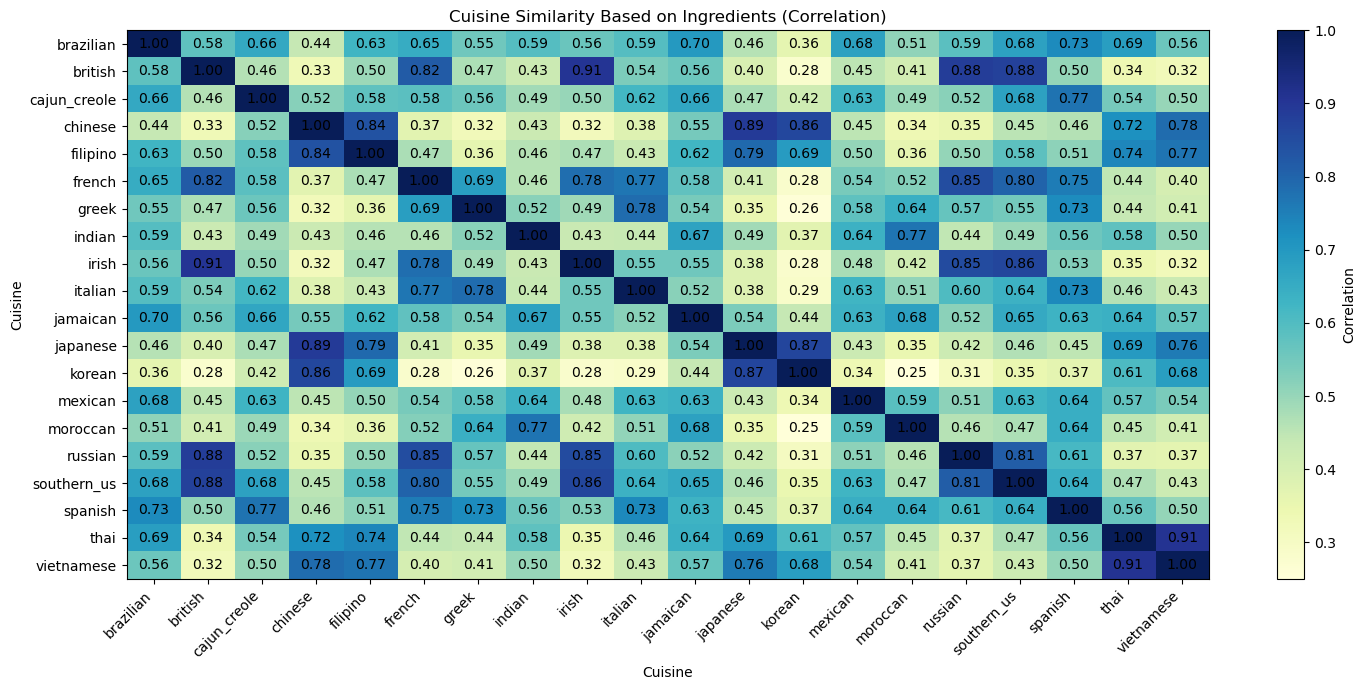

In [29]:
# Visualise the data on a correlation matrix
plt.figure(figsize=(15, 7))
plt.imshow(cuisine_correlation, cmap="YlGnBu", aspect="auto")

# Add numerical correlation values to each cell in the heatmap
for i in range(cuisine_correlation.shape[0]):
    for j in range(cuisine_correlation.shape[1]):
        plt.text(j, i, f"{cuisine_correlation.values[i, j]:.2f}", ha="center", va="center", color="black")

# To finalize the heatmap with proper labels and titles
plt.xticks(np.arange(len(cuisine_correlation.columns)), cuisine_correlation.columns, rotation=45, ha="right")
plt.yticks(np.arange(len(cuisine_correlation.index)), cuisine_correlation.index)
plt.colorbar(label="Correlation")
plt.title("Cuisine Similarity Based on Ingredients (Correlation)")
plt.xlabel("Cuisine")
plt.ylabel("Cuisine")
plt.tight_layout()
plt.show()

## Machine Learning

Partition the dataset with variables Response (Cuisine) and Predictor (Ingredients). As usual, the train size is 75% while the test set is the remaining 25%. The Y datasets are flattened into 1D NumPy array for compatability with the models

In [75]:
X = pd.DataFrame(recipe_data['ingredients_lem'])
y = pd.DataFrame(recipe_data['cuisine'])

# Split into test set (25%) and training set (75%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42,stratify=y)

# Convert to NumPy array and flatten into 1D array
y_train_flat = y_train.values.flatten()
y_test_flat = y_test.values.flatten()

# Check the sample sizes
print("Train Set:", X_train.shape, y_train_flat.shape)
print("Test Set:", X_test.shape, y_test_flat.shape)

Train Set: (29757, 1) (29757,)
Test Set: (9920, 1) (9920,)


### Transform the Datasets

Ingredient arrays are merged into a single string, and their count are recorded into a Bag-of-words (BoW) so the model can identify their frequencies in the cuisines 

In [150]:
# Step 1: Transform train & test sets
# Join ingredients into a single string with comma for each recipe
X_train['ingredients_str'] = X_train['ingredients_lem'].apply(lambda x:  ', '.join(x))
X_test['ingredients_str'] = X_test['ingredients_lem'].apply(lambda x:  ', '.join(x))

# Step 3: Feature Engineering (NLP) into bag of words
# Custom tokenizer function (splits ingredient names separated by commas)
def custom_tokenizer(text):
    # Split the input string by comma, remove extra spaces, and return the list of ingredients
    return [ingredient.strip() for ingredient in text.split(",")]

vectoriser = CountVectorizer(tokenizer = custom_tokenizer)

X_train_bow = vectoriser.fit_transform(X_train['ingredients_str']).toarray()
X_test_bow = vectoriser.transform(X_test['ingredients_str']).toarray()

print(vectoriser.get_feature_names_out()[100:200])

# Get the size of the train set and the vectorizer object
train_size, vector_size = X_train_bow.shape

print("Number of train ingredients:", train_size)
print("Train vector size:", vector_size)

c:\Users\Rayson\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['amchur' 'america' 'american cheese' 'american cheese food'
 'american cheese slices' 'amontillado sherry' 'ampalaya' 'anaheim chile'
 'anasazi beans' 'ancho' 'ancho chile pepper' 'ancho chili ground pepper'
 'ancho powder' 'anchovy' 'anchovy filets' 'anchovy fillets'
 'anchovy paste' 'and carrot green pea' 'and cook drain pasta ziti'
 'and fat free half half' 'andouille chicken sausage' 'andouille sausage'
 'andouille sausage links' 'andouille turkey sausages' 'angel food cake'
 'angel food cake mix' 'angel hair' 'angostura bitters' 'anise'
 'anise basil' 'anise extract' 'anise liqueur' 'anise oil' 'anise powder'
 'anise seed' 'anisette' 'anjou pears' 'annatto' 'annatto oil'
 'annatto powder' 'annatto seeds' 'any' 'aonori' 'apple' 'apple brandy'
 'apple butter' 'apple cider' 'apple cider vinegar' 'apple jelly'
 'apple juice' 'apple juice concentrate' 'apple pie filling'
 'apple pie spice' 'apple puree' 'apple schnapps' 'apple slice'
 'applesauce' 'applewood smoked bacon' 'apricot' 'a

### Random Forest Model

Create a Random Forest Model and fit the BoW and the flattened Y values. A classification report is printed once the fitting is done. For a train set of size ~30000, a 70-80% accuracy is the expected standard for a good model performance.

The default number of trees in the model is 100. We will shorten it down to 50 in order to reduce runtime though with negligible decrease in accuracy (0.002)

In [149]:
rf_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Fit train data to Random Forest model
rf_model.fit(X_train_bow, y_train_flat)

# Use model to make predictions on test data
y_pred_rf = rf_model.predict(X_test_bow)

# Evaluate model performance
print("Accuracy of Random Forest model:", accuracy_score(y_test_flat, y_pred_rf))
print(classification_report(y_test_flat, y_pred_rf))


Accuracy of Random Forest model: 0.7179435483870967
              precision    recall  f1-score   support

   brazilian       0.73      0.41      0.53       116
     british       0.67      0.29      0.40       201
cajun_creole       0.78      0.67      0.72       385
     chinese       0.68      0.86      0.76       667
    filipino       0.60      0.41      0.49       189
      french       0.55      0.53      0.54       659
       greek       0.74      0.57      0.64       293
      indian       0.78      0.89      0.83       749
       irish       0.56      0.35      0.43       167
     italian       0.70      0.88      0.78      1958
    jamaican       0.90      0.49      0.64       130
    japanese       0.76      0.59      0.67       354
      korean       0.81      0.55      0.65       207
     mexican       0.81      0.90      0.85      1607
    moroccan       0.84      0.60      0.70       205
     russian       0.56      0.29      0.38       122
 southern_us       0.67      

## AUC-ROC Random Forest

Receiver Operating Characteristic (ROC) curve represents the relationship of True Positive Rate (TPR) against False Positive Rate (FPR)

Area Under the ROC Curve summarises the performance of the model based on classification. It ranges between 0 to 1. A value of 0.5 indicates the model is performing no better than random guessing, and below 0.5 means it will be worse. 

In [ ]:
# Generate predicted probabilities (for AUC-ROC calculation)
y_pred_proba_rf = rf_model.predict_proba(X_test_bow)
print(y_pred_proba_rf.shape)
print(y_test_flat)

from sklearn.preprocessing import LabelBinarizer

# Binarize y_test_flat to get one-vs-rest format for ROC curve calculation
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test_flat)

# Step 3: Calculate AUC-ROC score (One-vs-Rest strategy for multi-class classification)
try:
    auc_rf = roc_auc_score(y_test_binarized, y_pred_proba_rf, multi_class='ovr')
    print("Area Under Curve (AUC) for Random Forest model ROC curve:", auc_rf)
except ValueError as e:
    print("AUC calculation error:", e)

# Step 4: Plot the ROC Curve for each class
unique_classes = np.unique(y_test_flat)
print("Unique classes in y_test_flat:", unique_classes)
n_classes = len(unique_classes)
print(n_classes)
fpr_rf = {}
tpr_rf = {}
roc_auc_rf = {}

# Calculate ROC for each class
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])


(9920, 20)
['thai' 'mexican' 'mexican' ... 'mexican' 'mexican' 'chinese']
Area Under Curve (AUC) for Random Forest model ROC curve: 0.9360337348898227
Unique classes in y_test_flat: ['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']
20


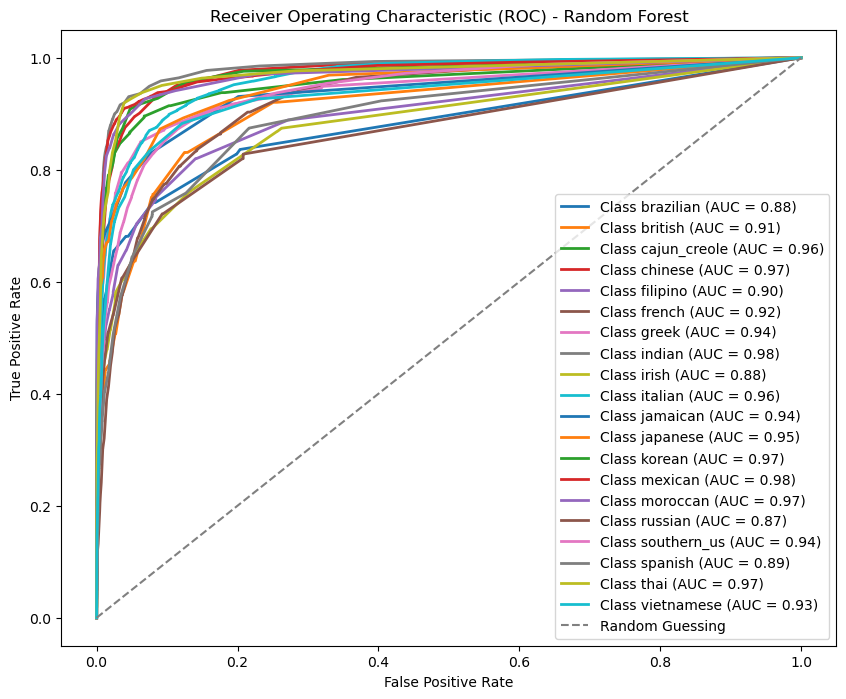

In [118]:
# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    if not np.isnan(roc_auc_rf[i]):  # Only plot if AUC was calculated
        plt.plot(fpr_rf[i], tpr_rf[i], lw=2, label=f'Class {unique_classes[i]} (AUC = {roc_auc_rf[i]:.2f})')

# Plot the random chance line (diagonal)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc='lower right')
plt.show()

### Feature Importance

A huge advantage of Random Forest is its built-in Feature Importance ability that shows the most important features in determining a prediction. Thus, we will show the top 10 key ingredients used to predict the cuisines.

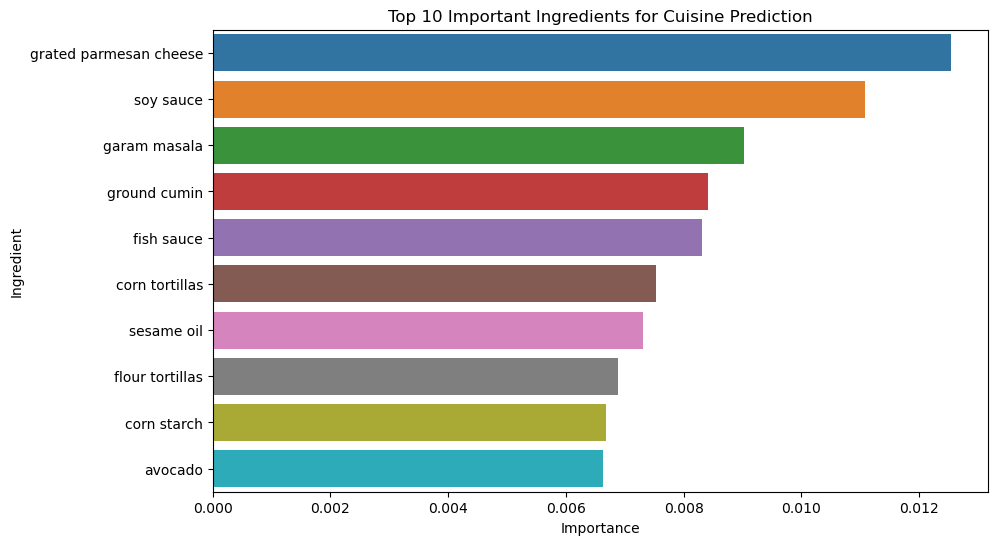

In [151]:
#Check for importance of ingredients for RandomForest model (Feature Importance)

importances = rf_model.feature_importances_
feature_names = vectoriser.get_feature_names_out()


importance_df = pd.DataFrame({'Ingredient': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10,6))
sb.barplot(x="Importance",y="Ingredient", data=importance_df.head(10))
plt.title('Top 10 Important Ingredients for Cuisine Prediction')
plt.show()


## Logistic Regression Model

Create a Logistic Regression model with max_iter = 300, a reasonable value to balance between convergence issues (too low) and computation time (too high)

Similar to Random Forest, a classification report will be output

In [119]:
# Create a multinomial logistic regression model
logreg_model = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial', max_iter = 300).fit(X_train_bow, y_train_flat)

#Fit train data to logistic regression model
logreg_model.fit(X_train_bow, y_train_flat)

# Use model to make predictions on test data
y_pred_logreg = logreg_model.predict(X_test_bow)

# Evaluate model performance
print("Accuracy of the best Logistic Regression model:", accuracy_score(y_test_flat, y_pred_logreg))
print(classification_report(y_test_flat, y_pred_logreg))

Accuracy of the best Logistic Regression model: 0.7731854838709677
              precision    recall  f1-score   support

   brazilian       0.75      0.49      0.59       116
     british       0.58      0.41      0.48       201
cajun_creole       0.78      0.69      0.73       385
     chinese       0.78      0.84      0.81       667
    filipino       0.74      0.57      0.64       189
      french       0.58      0.65      0.62       659
       greek       0.79      0.66      0.72       293
      indian       0.87      0.88      0.88       749
       irish       0.58      0.46      0.51       167
     italian       0.78      0.89      0.83      1958
    jamaican       0.84      0.67      0.75       130
    japanese       0.80      0.68      0.74       354
      korean       0.81      0.72      0.76       207
     mexican       0.89      0.92      0.90      1607
    moroccan       0.87      0.76      0.81       205
     russian       0.70      0.41      0.52       122
 southern_us  

## AUC-ROC Logistic Regression

Similar to Random Forest, An AUC-ROC evaluation will be run for Logistic Regression

In [120]:
# Generate predicted probabilities (for AUC-ROC calculation)
y_pred_proba_lr = logreg_model.predict_proba(X_test_bow)
print(y_pred_proba_lr.shape)
print(y_test_flat)

from sklearn.preprocessing import LabelBinarizer

# Binarize y_test_flat to get one-vs-rest format for ROC curve calculation
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test_flat)

# Step 3: Calculate AUC-ROC score (One-vs-Rest strategy for multi-class classification)
try:
    auc_lr = roc_auc_score(y_test_binarized, y_pred_proba_lr, multi_class='ovr')
    print("Area Under Curve (AUC) for Log Reg model ROC curve:", auc_lr)
except ValueError as e:
    print("AUC calculation error:", e)

# Step 4: Plot the ROC Curve for each class
print("Unique classes in y_test_flat:", np.unique(y_test_flat))
unique_classes = np.unique(y_test_flat)
n_classes = len(unique_classes)
print(n_classes)
fpr_lr = {}
tpr_lr = {}
roc_auc_lr = {}

# Calculate ROC for each class
for i in range(n_classes):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_lr[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])


(9920, 20)
['thai' 'mexican' 'mexican' ... 'mexican' 'mexican' 'chinese']
Area Under Curve (AUC) for Log Reg model ROC curve: 0.9687128227306534
Unique classes in y_test_flat: ['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']
20


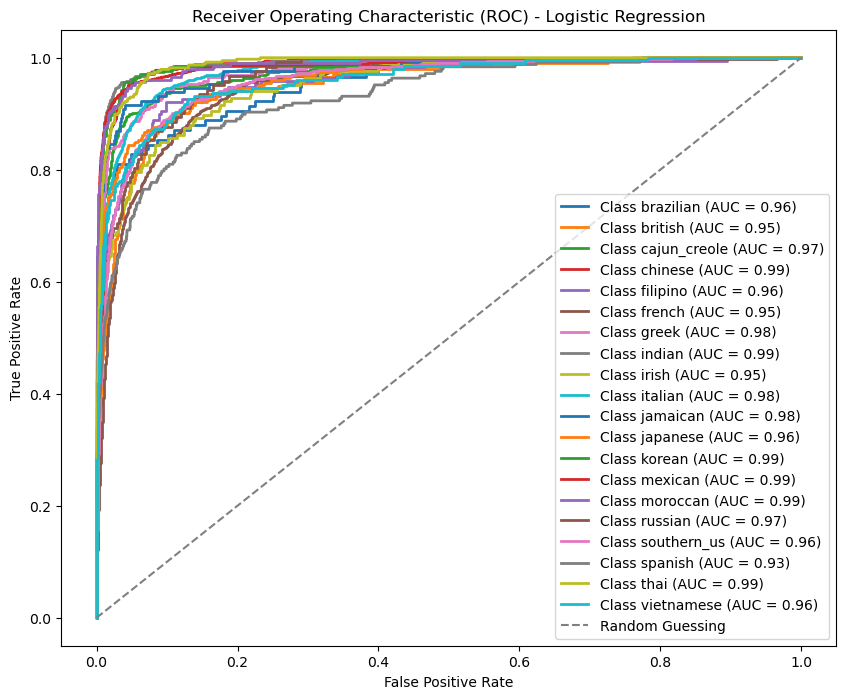

In [121]:
# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    if not np.isnan(roc_auc_lr[i]):  # Only plot if AUC was calculated
        plt.plot(fpr_lr[i], tpr_lr[i], lw=2, label=f'Class {unique_classes[i]} (AUC = {roc_auc_lr[i]:.2f})')

# Plot the random chance line (diagonal)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

## Feature Importance

Unlike Random Forest, Logistic Regression does not have a built-in feature importance function. So we will instead manually calculate the importance by extracting the model coefficients, finding their average using the numpy.mean() function and extracting their features with the count_vectoriser.

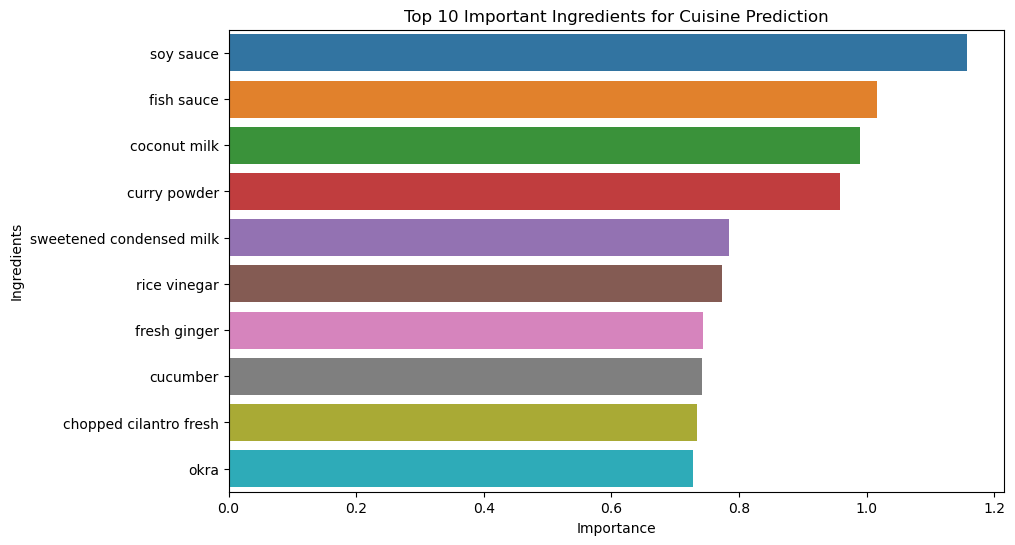

In [152]:
# Check for importance of ingredients for Log Reg model (Feature Importance)
coefficients = logreg_model.coef_


# Calculate feature importance by taking the average of the absolute values of the coefficients across all classes.
avg_importance = np.mean(np.abs(coefficients), axis = 0)
feature_names = vectoriser.get_feature_names_out()

feature_importance = pd.DataFrame({"Ingredients": feature_names, "Importance": avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
#feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.figure(figsize=(10,6))
sb.barplot(x = "Importance", y = "Ingredients", data= feature_importance.head(10))
plt.title('Top 10 Important Ingredients for Cuisine Prediction')
plt.show()

## Confusion Matrix

Visual representation of the percentage of correct classifications and misclassifications, across the different cuisines for both models

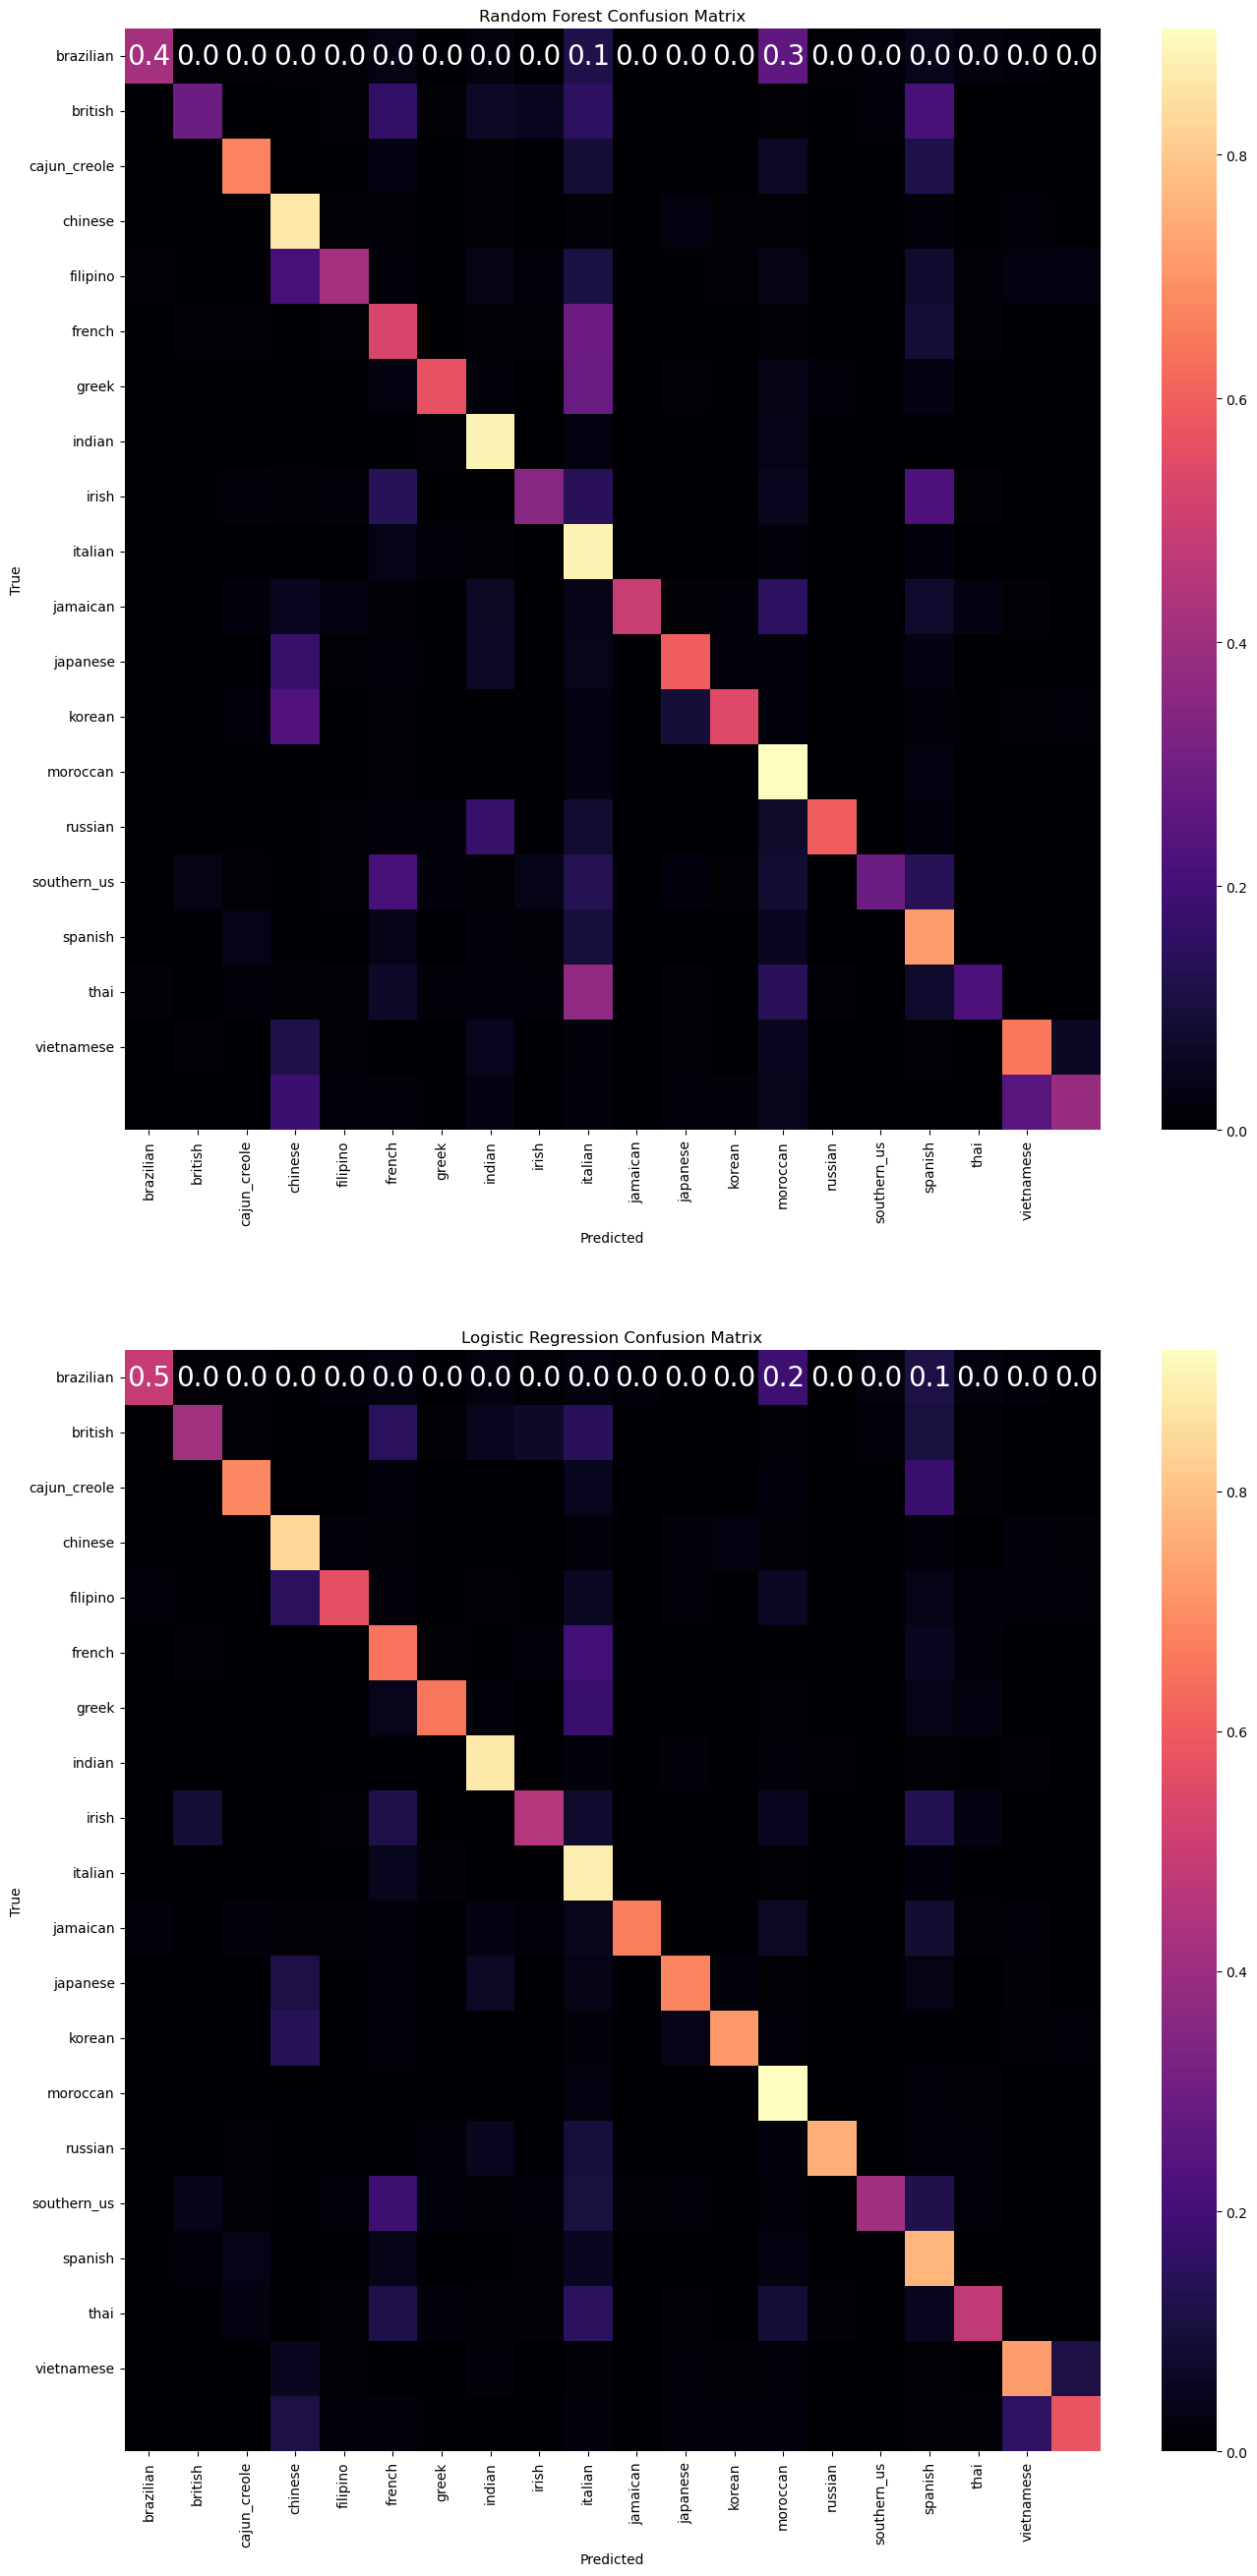

In [155]:
# Model Evaluation
# Plot the Confusion Matrix for both models
cuisine_names = ['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french',
                 'greek', 'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean',
                  'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']

f, axes = plt.subplots(2, 1, figsize=(16, 32))

# Confusion matrix for Random Forest model
sb.heatmap(confusion_matrix(y_test_flat, y_pred_rf, normalize='true'), # Normalize to percentages
           annot=True, fmt=".1f", annot_kws={"size": 20}, ax=axes[0], cmap="magma",
           xticklabels=cuisine_names, yticklabels=cuisine_names)
axes[0].set_title("Random Forest Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Confusion matrix for Logistic Regression model
sb.heatmap(confusion_matrix(y_test_flat, y_pred_logreg, normalize='true'),  # Normalize to percentages
           annot=True, fmt=".1f", annot_kws={"size": 20}, ax=axes[1], cmap="magma",
           xticklabels=cuisine_names, yticklabels=cuisine_names)
axes[1].set_title("Logistic Regression Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.show()